In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/home/vevurka/.conda/envs/py36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
data_length = 15000
stocks = ['9064', '9061', '9265']

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
for s in stocks:
    print(s)
    print(min(d_stocks[s].index), max(d_stocks[s].index))
    print(min(d_test_stocks[s].index), max(d_test_stocks[s].index))

9064
2013-09-12 14:41:00 2013-11-05 13:32:00
2013-09-02 09:00:00 2013-09-12 14:40:00
9061
2013-09-13 10:36:00 2013-11-06 14:54:00
2013-09-02 09:00:00 2013-09-13 10:35:00
9265
2013-09-16 09:45:00 2013-11-12 12:36:00
2013-09-02 09:00:00 2013-09-16 09:44:00


## Data visualization

#### Density Queue imbalance vs mid price

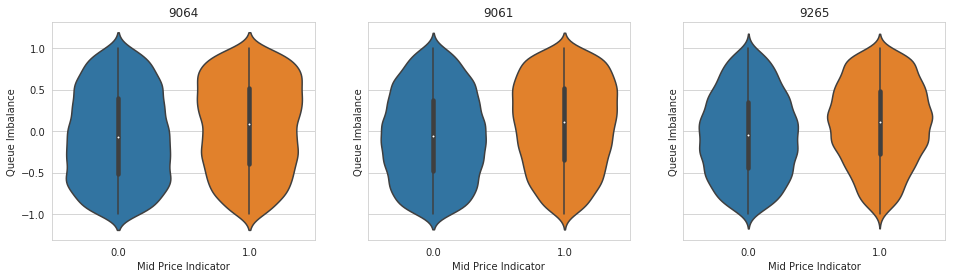

In [5]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
i = 0
plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')
for k, d in d_stocks.items():
    sns.violinplot(y=d['queue_imbalance'], x=d['mid_price_indicator'], ax=ax[i])
    ax[i].set_title(k)
    ax[i].set_ylabel('Queue Imbalance')
    ax[i].set_xlabel('Mid Price Indicator')
    i += 1

plt.ylabel('Queue Imbalance')
plt.xlabel('Mid Price Indicator')
plt.savefig('violin_plot_imb_vs_ind.png')

Text(0.5,1,'Queue Imbalance vs Mid Price Indicator')

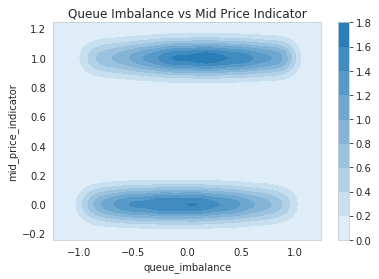

In [6]:
sns.kdeplot(d['queue_imbalance'], d['mid_price_indicator'], shade=True, cbar=True)
plt.title('Queue Imbalance vs Mid Price Indicator')

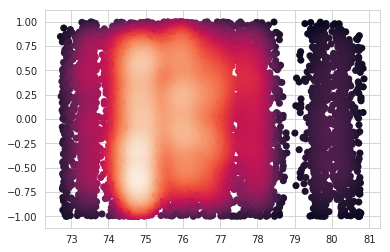

<Figure size 432x288 with 0 Axes>

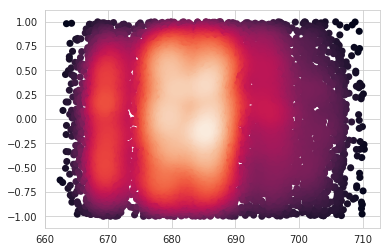

<Figure size 432x288 with 0 Axes>

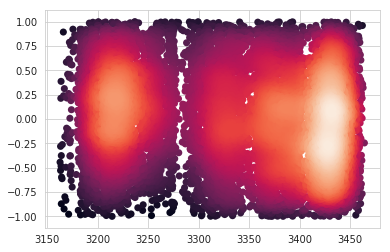

<Figure size 432x288 with 0 Axes>

In [7]:
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[0]], 0, len(d_stocks[stocks[0]]))
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[1]], 0, len(d_stocks[stocks[1]]))
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[2]], 0, len(d_stocks[stocks[2]]))

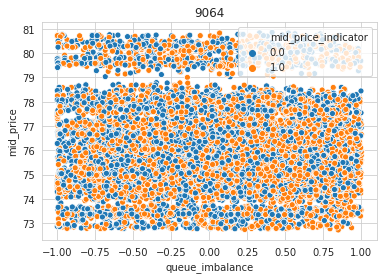

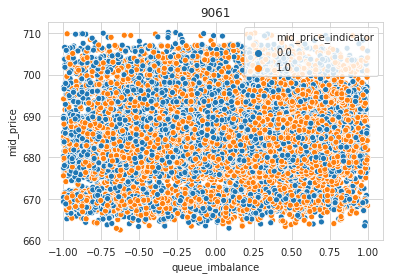

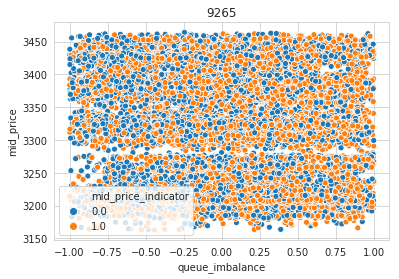

<Figure size 432x288 with 0 Axes>

In [8]:
for k, d in d_stocks.items():
    sns.scatterplot(d['queue_imbalance'], d['mid_price'], hue=d['mid_price_indicator'])
    plt.title(k)
    plt.figure()

#### Mid Price Visualization

12000
12000
12000


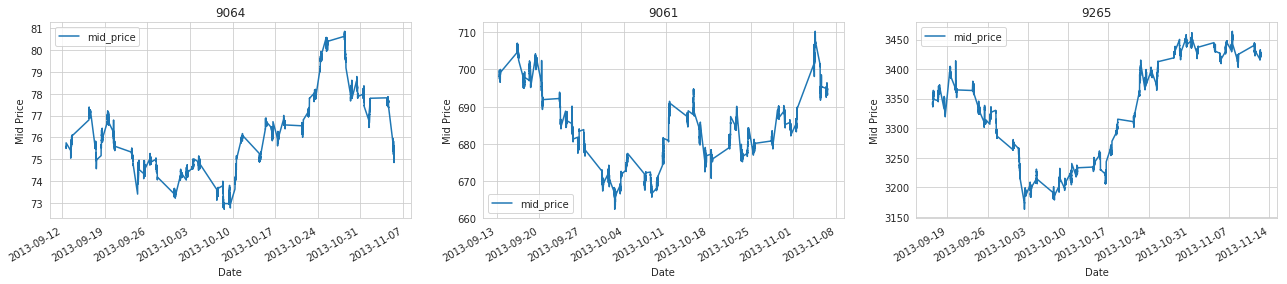

In [9]:
f, ax = plt.subplots(1, 3, figsize=(22, 4))
for i in range(len(stocks)):
    print(len(d_stocks[stocks[i]]))
    d_stocks[stocks[i]][['mid_price']].plot(label=stocks[i], ax=ax[i])
    ax[i].set_title(stocks[i])
    ax[i].set_ylabel('Mid Price')
    ax[i].set_xlabel('Date')
    ax[i].legend()

plt.legend()
plt.savefig('mid_price.png')

## Logistic

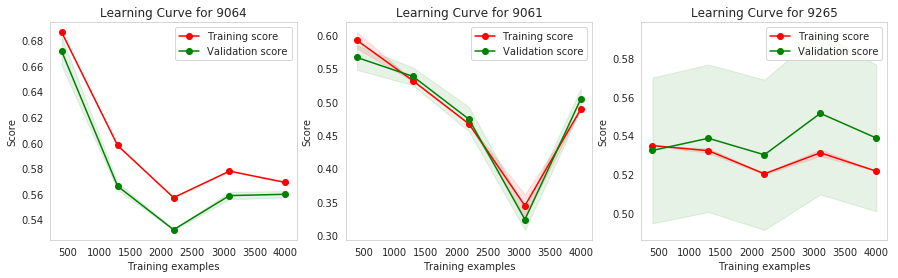

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    lob.plot_learning_curve(
        log_clf, d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1),
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=2), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
plt.savefig('logistic_regression_learning_curves.png')

12000 3000
12000 3000
12000 3000


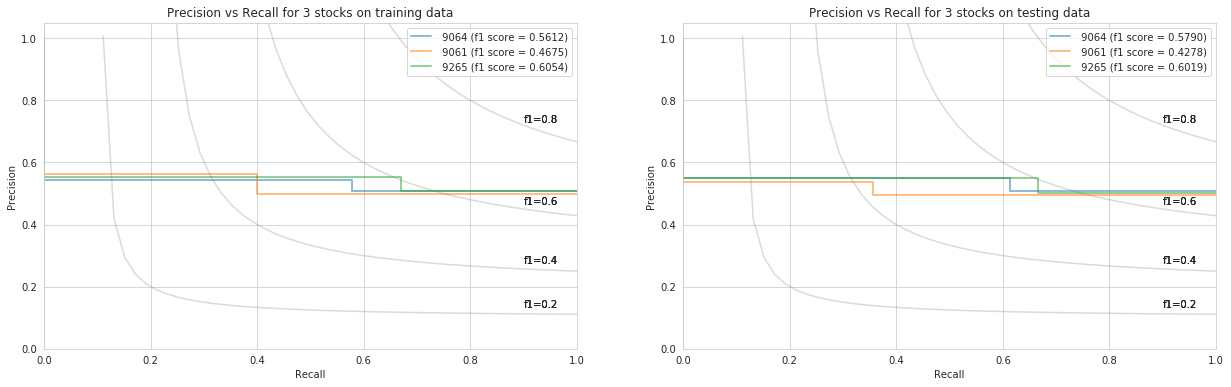

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21,6))
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    pred_train = log_clf.predict(d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_test = log_clf.predict(d_test_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    d_stocks[stock]['pred_log'] = pred_train
    d_test_stocks[stock]['pred_log'] = pred_test
    print(len(d_stocks[stock]), len(d_test_stocks[stock]) )
    lob.plot_f1(d_stocks[stock], log_clf, stock=stock, label='', ax=ax1,
                 title='Precision vs Recall for 3 stocks on training data')
    lob.plot_f1(d_test_stocks[stock], log_clf, stock=stock, label='', ax=ax2,
                 title='Precision vs Recall for 3 stocks on testing data')
    plt.savefig('logistic_regression_precision_vs_recall.png')

In [12]:
def get_scores_dict_for_data(functions_to_run, dfs, clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score,
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    dfs = {'test': d_test_stocks[stock]}
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    
    res_train = model.validate_model(LogisticRegression(), d_stocks[stock][['queue_imbalance']], 
                         d_stocks[stock]['mid_price_indicator'])
    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [13]:
df_scores.columns

Index(['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1_score', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc'],
      dtype='object')

In [14]:
df_scores[['train_precision', 'precision', 'test_precision', 'train_recall', 'recall', 'test_recall']]

,train_precision,precision,test_precision,train_recall,recall,test_recall
9064,"[0.5304709141274239, 0.5401396160558464, 0.539...","[0.5184135977337111, 0.5717017208413002, 0.537...",0.547564,"[0.6790780141843972, 0.5658135283363802, 0.615...","[0.690566037735849, 0.5209059233449478, 0.5384...",0.618611
9061,"[0.5611390284757118, 0.53375, 0.52487135506003...","[0.48, 0.5054945054945055, 0.5976331360946746,...",0.530792,"[0.6057866184448463, 0.41256038647342996, 0.39...","[0.6224066390041494, 0.3552123552123552, 0.375...",0.486232
9265,"[0.5602536997885835, 0.5528846153846154, 0.551...","[0.567032967032967, 0.5347091932457786, 0.5363...",0.560217,"[0.500945179584121, 0.5324074074074074, 0.5149...","[0.46823956442831216, 0.5397727272727273, 0.53...",0.551265


In [15]:
df_scores[['train_f1', 'f1', 'test_f1_score', 'train_roc_auc', 'roc_auc', 'test_roc_auc']]

,train_f1,f1,test_f1_score,train_roc_auc,roc_auc,test_roc_auc
9064,"[0.5956454121306377, 0.5526785714285714, 0.574...","[0.5922330097087378, 0.545123062898815, 0.5379...",0.580923,"[0.517295661084594, 0.5402732466727942, 0.5344...","[0.541711590296496, 0.5433986981065824, 0.5366...",0.544719
9061,"[0.5826086956521739, 0.4653950953678474, 0.450...","[0.5420054200542005, 0.41723356009070295, 0.46...",0.507536,"[0.5589454507494249, 0.543398097166846, 0.5357...","[0.5439335826599695, 0.5202635202635203, 0.564...",0.531336
9265,"[0.5289421157684631, 0.5424528301886793, 0.532...","[0.5129224652087475, 0.5372290292177191, 0.534...",0.555705,"[0.5650893455852869, 0.5548400673400673, 0.554...","[0.5513739566111876, 0.5492457942413458, 0.540...",0.558677


In [19]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
9064,0.564138,0.084744,0.085573,0.547282,0.585204,0.542407,9064,0.580923,0.089644,0.090439,0.547564,0.618611,0.544719,0.572903,0.069837,0.070440,0.540994,0.609651,0.534826
9061,0.514810,0.096084,0.098933,0.552271,0.495421,0.548301,9061,0.507536,0.062710,0.062929,0.530792,0.486232,0.531336,0.511707,0.090715,0.091511,0.540305,0.488909,0.545188
9265,0.556864,0.104161,0.104973,0.561480,0.556229,0.552151,9265,0.555705,0.117351,0.117366,0.560217,0.551265,0.558677,0.552552,0.109778,0.110015,0.554104,0.552175,0.554834


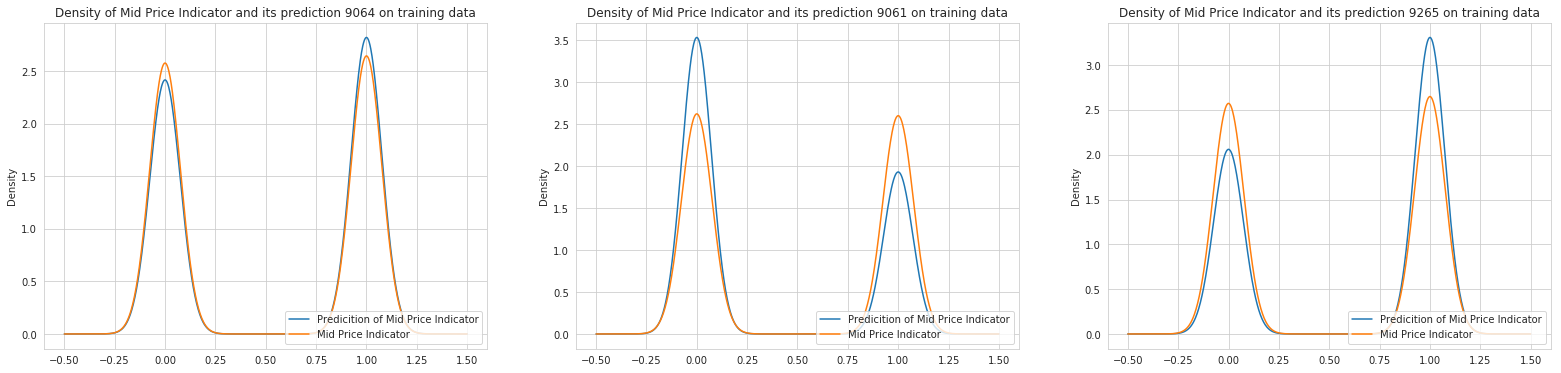

In [17]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    d_stocks[stock][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(stock))
    ax[i].legend(loc='lower right')
plt.savefig('density_of_mid_price_and_prediction_training_data.png')

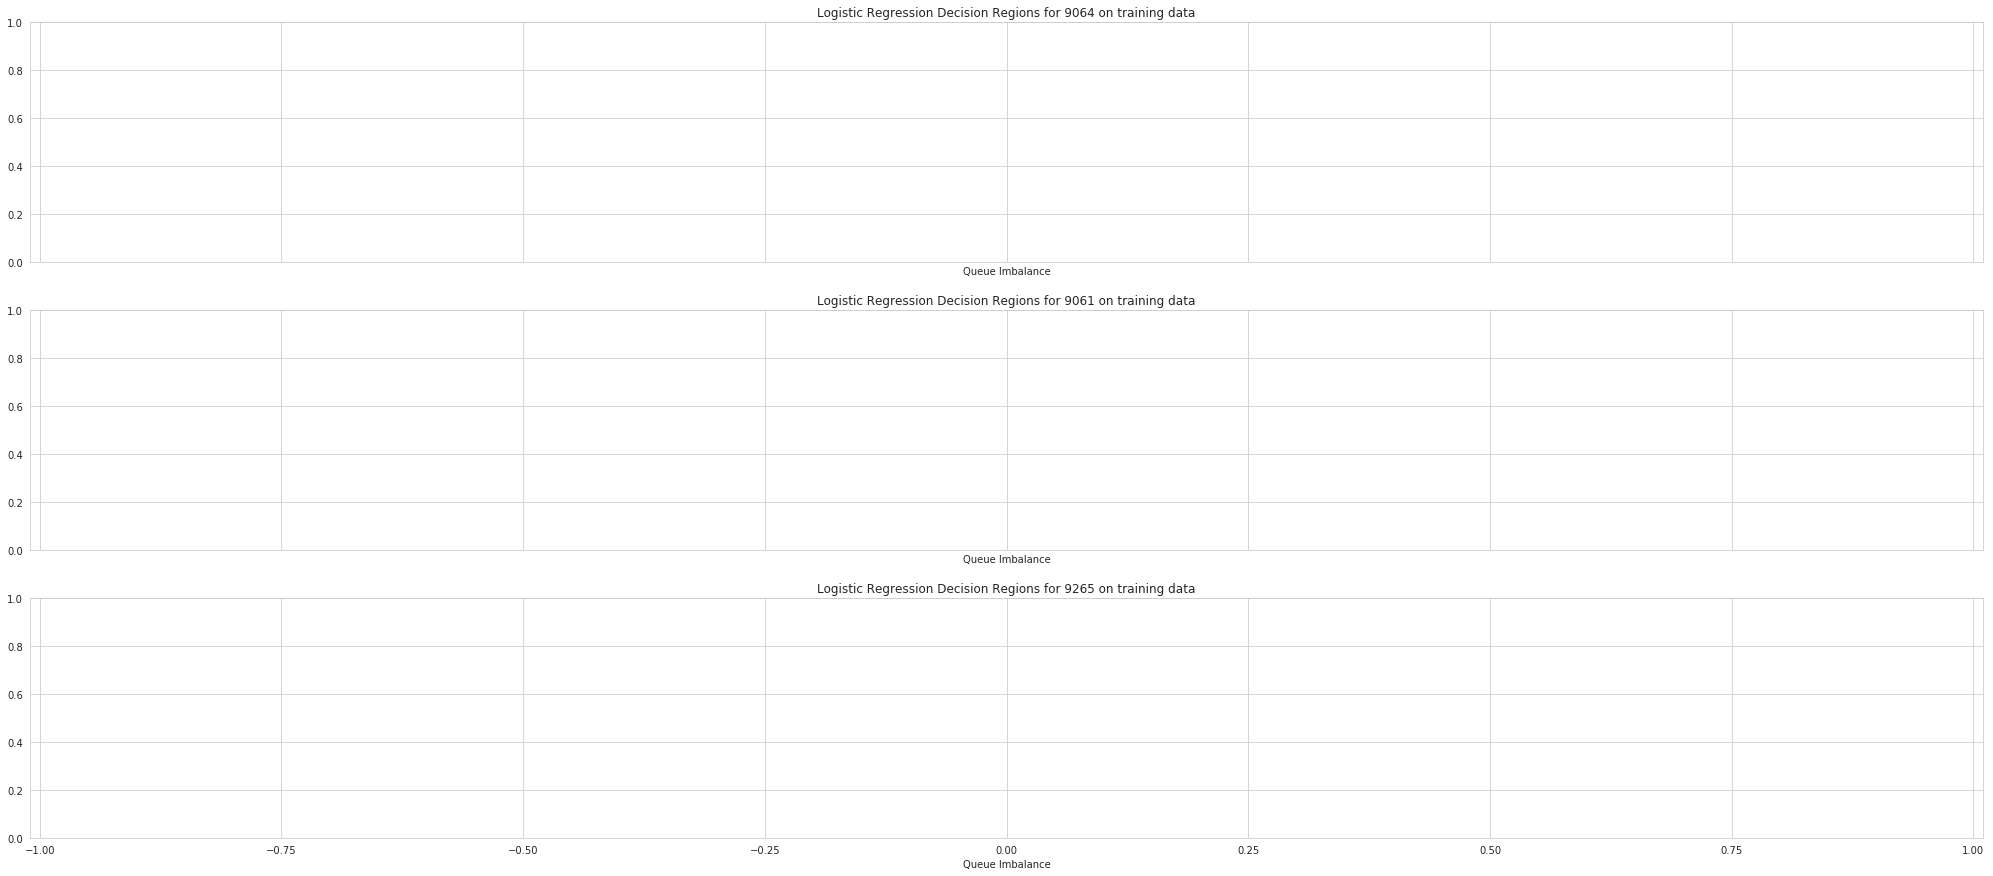

In [18]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    stock = stocks[i]
    df = d_stocks[stock]
    X = df[['queue_imbalance']].values
    y = df['mid_price_indicator'].values.astype(np.integer)

    clf = lob.logistic_regression(df, 0, len(df))
    plot_decision_regions(X[0:900], y[0:900], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('Logistic Regression Decision Regions for {} on training data'.format(stock))
    ax[i].set_xlim(-1.01, 1.01)


# plt.savefig('logistic_regression_decision_region.png'.format(s))